# **ANÁLISIS DE SERIES TEMPORALES Y OPTIMIZACIÓN DE MODELOS MEDIANTE ALGORITMOS DE OPTIMIZACIÓN**

**INTRODUCCIÓN A LA IA: ENTREGA FINAL**

**Profesor:**

Yomin Jaramillo Múnera

**Integrantes:**

Yeniffer Andrea Córdoba

Pablo Gómez Mutis

Luz Adriana Yepes

## **1. Introducción**

**¿En qué consiste este proyecto?**

Este proyecto se enfocará en la implementación de **algoritmos de optimización aplicados a series de tiempo**, específicamente a una serie de tiempo que refleja la varia-ción del precio de la vivienda a lo largo de doce años (2007-2019). Este análisis tomará en cuenta diversas variables, como el número de habitaciones y el tipo de vivienda (ca-sa o apartamento).

Para el modelamiento de las series de tiempo, utilizaremos dos modelos estadísticos tradicionales: **ARIMA** (univariado) y **VAR** (multivariado). Además, con fines comparativos, incluiremos un modelo de machine learning: **Random Forest**. Cada uno de estos modelos será inicialmente ejecutado con sus parámetros estándar.

Posteriormente, aplicaremos dos algoritmos de optimización estudiados en clase: **Hill Climbing** (búsqueda local) y **Algoritmo Genético** (optimización evolutiva). El mejoramiento en el rendimiento de cada modelo se presentará gráficamente, y se proporcionarán los valores originales y optimizados de MSE (Error Cuadrático Medio) y RMSE (Raíz del Error Cuadrático Medio).

Finalmente, se realizará una comparación del rendimiento de todos los modelos de series de tiempo optimizados para identificar la opción más adecuada.


**¿Cómo ejecutar este código?**

- Cargar el archivo iadataset.csv se encuentra en el mismo repositorio Github donde está ubicado este código.

- Cargarlo en el entorno de trabajo y asignarlo al DataFrame llamado df.

- Las instalación de las librerías necesarias está implícita a lo largo del código.



## **2. Exploración y preprocesamiento**

### 2.1. Cargar el dataset

Comenzamos por cargar nuestro dataset "**iadataset.csv**" desde nuestro Drive, al que se le asignará el nombre de "df".

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/iadataset.csv")
df.head()

,saledate,MA,type,bedrooms
0,30/09/2007,441854,house,2
1,31/12/2007,441854,house,2
2,31/03/2008,441854,house,2
3,30/06/2008,441854,house,2
4,30/09/2008,451583,house,2


### 2.2. Explorar los datos

Exploramos el modo en el que los datos están distribuidos para entenderlos mejor.

- **Saledate**: El dataset registra ventas que van desde 2007 hasta 2019. Vemos una distribución uniforme en la cantidad de ventas anuales, a excepción del primer y último año (2007 y 2019), que son ligeramente menores.

- **Precio (MA)**: El precio medio es la variable con variaciones más acentuadas. Vemos que hay ciertos rangos de precios más comunes que otros, pero, de igual forma, la variable está muy distribuida.

- **Type**: En cuanto al tipo, hay solo dos opciones (house, unit), siendo el tipo house considerablemente más común que unit.

- **Bedrooms**: Los números de habitaciones más comunes son 2 y 3, mientras que 1, 4 y 5 son considerablemente menos frecuentes.

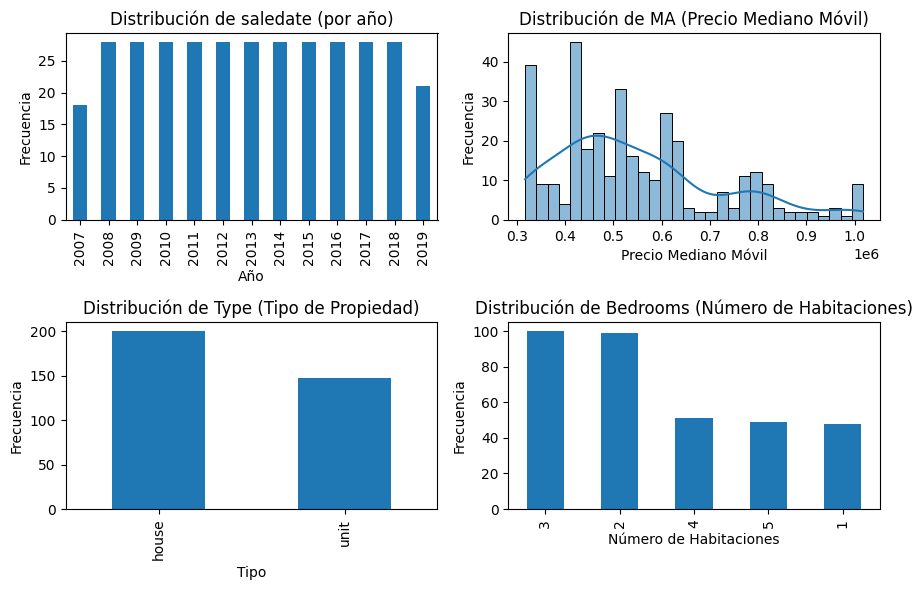

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df['saledate'] = pd.to_datetime(df['saledate'], dayfirst=True)
plt.figure(figsize=(9, 6))

plt.subplot(2, 2, 1)
df['saledate'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de saledate (por año)')
plt.xlabel('Año')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 2)
sns.histplot(df['MA'], bins=30, kde=True)
plt.title('Distribución de MA (Precio Mediano Móvil)')
plt.xlabel('Precio Mediano Móvil')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 3)
df['type'].value_counts().plot(kind='bar')
plt.title('Distribución de Type (Tipo de Propiedad)')
plt.xlabel('Tipo')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 4)
df['bedrooms'].value_counts().plot(kind='bar')
plt.title('Distribución de Bedrooms (Número de Habitaciones)')
plt.xlabel('Número de Habitaciones')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [ ]:
df.describe().round()

,saledate,MA,bedrooms
count,347,347.0,347.0
mean,2013-09-02 15:50:19.020172800,548132.0,3.0
min,2007-03-31 00:00:00,316751.0,1.0
25%,2010-06-30 00:00:00,427740.0,2.0
50%,2013-09-30 00:00:00,507744.0,3.0
75%,2016-09-30 00:00:00,627516.0,4.0
max,2019-09-30 00:00:00,1017752.0,5.0
std,NaN,170193.0,1.0


### 2.3. Correlación entre variables

Vemos las correlaciones entres las distintas variables del dataframe. La variable objetivo en este caso es el precio (MA).

- **Bedrooms**: Existe una correlación positiva muy alta (0.92) con el precio (MA), lo cual sugiere que a mayor número de habitaciones, mayor es el precio promedio.

- **Type**: Hay una correlación negativa considerable (-0.55).

- **Saledate**: Aunque muestra una correlación positiva baja (0.27), esta variable es relevante porque refleja la evolución temporal de los precios. Aunque la relación no sea muy fuerte, el hecho de que los precios cambien ligeramente con el tiempo es un aspecto importante que debe considerarse en el análisis completo.

Por los motivos apenas explicados, todas las variables serán consideradas en los modelos de predicción.

In [ ]:
df_encoded = df.copy()
df_encoded['type'] = df_encoded['type'].astype('category').cat.codes
df_encoded['bedrooms'] = pd.to_numeric(df_encoded['bedrooms'], errors='coerce')
correlation_matrix = df_encoded.corr()
correlation_with_MA = correlation_matrix['MA'].sort_values(ascending=False)
print(correlation_with_MA)


MA          1.000000
bedrooms    0.921603
saledate    0.264353
type       -0.546780
Name: MA, dtype: float64


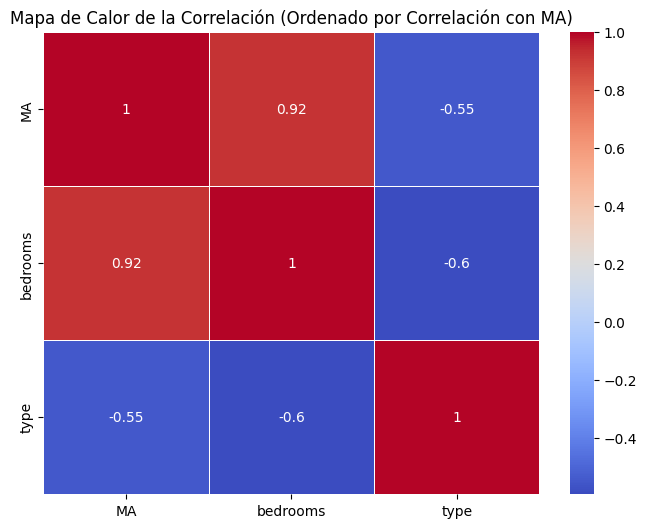

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_encoded = df.copy()
df_encoded['type'] = df_encoded['type'].astype('category').cat.codes
df_encoded['bedrooms'] = pd.to_numeric(df_encoded['bedrooms'], errors='coerce')
correlation_matrix = df_encoded.drop(columns=['saledate']).corr()

correlation_with_MA = correlation_matrix['MA'].sort_values(ascending=False)
sorted_index = correlation_with_MA.index
sorted_correlation_matrix = correlation_matrix.loc[sorted_index, sorted_index]

plt.figure(figsize=(8, 6))
sns.heatmap(sorted_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor de la Correlación (Ordenado por Correlación con MA)')
plt.show()

### 2.4. Outliers

Por medio de los boxplots, identificamos la presencia de **outliers** en las variables. Observamos que únicamente la variable MA muestra outliers. Sin embargo, decidimos no eliminarlos ya que no representan errores en los datos, sino que corresponden a precios inusuales pero válidos. Estos valores atípicos muestran ventas con características particulares que, aunque son poco comunes, ocurrieron de manera real y pueden ser relevantes para el análisis.

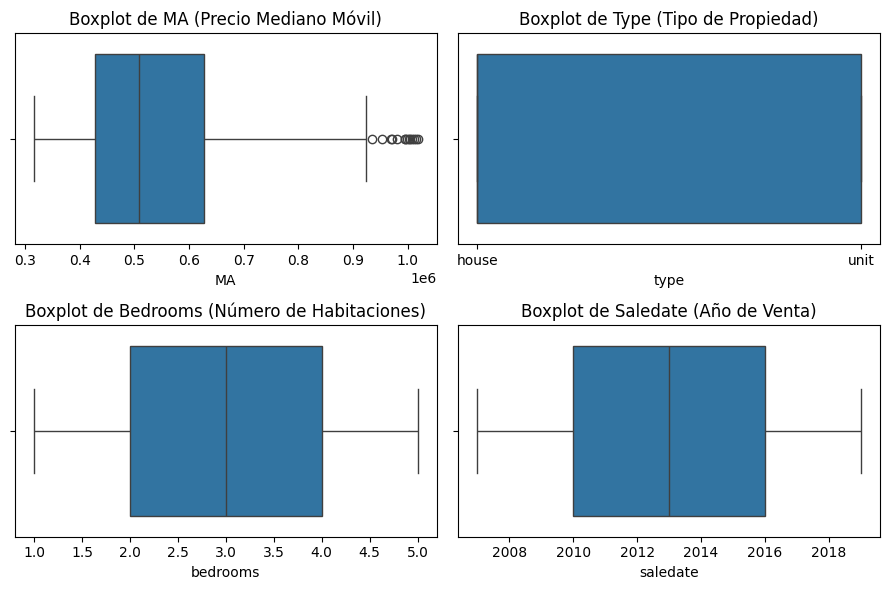

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 6))

plt.subplot(2, 2, 1)
sns.boxplot(x=df['MA'])
plt.title('Boxplot de MA (Precio Mediano Móvil)')

plt.subplot(2, 2, 2)
sns.boxplot(x=df['type'])
plt.title('Boxplot de Type (Tipo de Propiedad)')

plt.subplot(2, 2, 3)
sns.boxplot(x=df['bedrooms'])
plt.title('Boxplot de Bedrooms (Número de Habitaciones)')

plt.subplot(2, 2, 4)
sns.boxplot(x=df['saledate'].dt.year)
plt.title('Boxplot de Saledate (Año de Venta)')

plt.tight_layout()
plt.show()

### 2.5. Valores nulos y duplicados

Con estos dos comandos revisamos si hay algún valor **nulo** o alguna fila **duplicada** en el dataset. Afortunadamente, este no es el caso, por lo que podemos continuar con el análisis.

In [ ]:
df.isnull().sum().sum()

np.int64(0)

In [ ]:
df.duplicated().sum()

np.int64(0)

## **3. ARIMA**

El primer modelo que implementaremos en el proyecto es el **ARIMA (Autoregressive Integrated Moving Average)**. Este es un modelo estadístico tradicional utilizado en series de tiempo. Es el más simple de todos aquellos que utilizaremos por su estructura univariada.

- Destaca por ser uno de los modelos más populares para series de tiempo.

- ¡Es **univariado**! Lo que quiere decir que tendrá en cuenta solo las fechas y la variable objetivo precio. Las demás variables NO se tienen en consideración en este modelo.

- Captura tres componentes: **Autoregresión** (AR), **Diferenciación** (I, Integrated) y **Media Móvil** (MA).

  -  Autorregresivo (AR): Utiliza valores pasados de la serie para predecir el valor actual.

  - Integrado (I): Aplica diferenciación para lograr que la serie sea estacionaria.

  - Media Móvil (MA): Modela la relación entre el valor actual y los errores de predicción anteriores.

### 3.1. Modelo original

Los pasos a seguir para establecer el modelo son los siguientes:

- Importar las bibliotecas necesarias

- Preparar los datos (que saledate esté en formato fecha y ordenada cronológicamente)

- Dividir los datos en conjuntos de entrenamiento y prueba (80% y 20%)

- Ajustar el modelo ARIMA (se establecen los parámetros estándar del modelo: 1, 1, 1)

- Realizar predicciones

- Evaluar el modelo

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Error cuadrático medio (MSE): 45260747979.29171
Raíz del error cuadrático medio (RMSE): 212745.7355137623


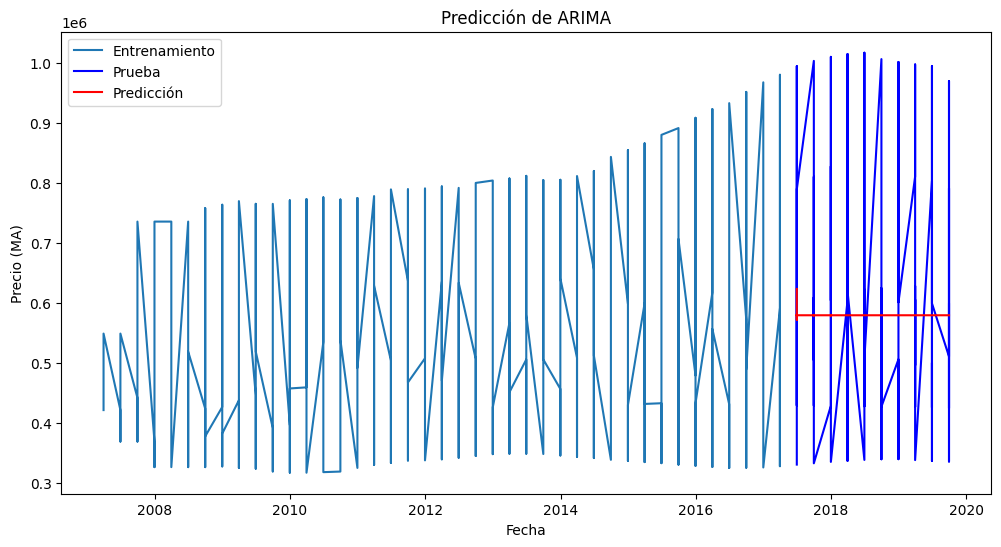

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

df['saledate'] = pd.to_datetime(df['saledate'], dayfirst=True)
df.set_index('saledate', inplace=True, drop=False)

df.sort_index(inplace=True)

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

model = ARIMA(train['MA'], order=(1, 1, 1))
fitted_model = model.fit()

forecast = fitted_model.forecast(steps=len(test))

rmse = np.sqrt(mse)
print(f'Error cuadrático medio (MSE): {mse}')
print(f'Raíz del error cuadrático medio (RMSE): {rmse}')

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['MA'], label='Entrenamiento')
plt.plot(test.index, test['MA'], label='Prueba', color='blue')
plt.plot(test.index, forecast, label='Predicción', color='red')
plt.xlabel('Fecha')
plt.ylabel('Precio (MA)')
plt.title('Predicción de ARIMA')
plt.legend()
plt.show()

### 3.2. Hill Climbing

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

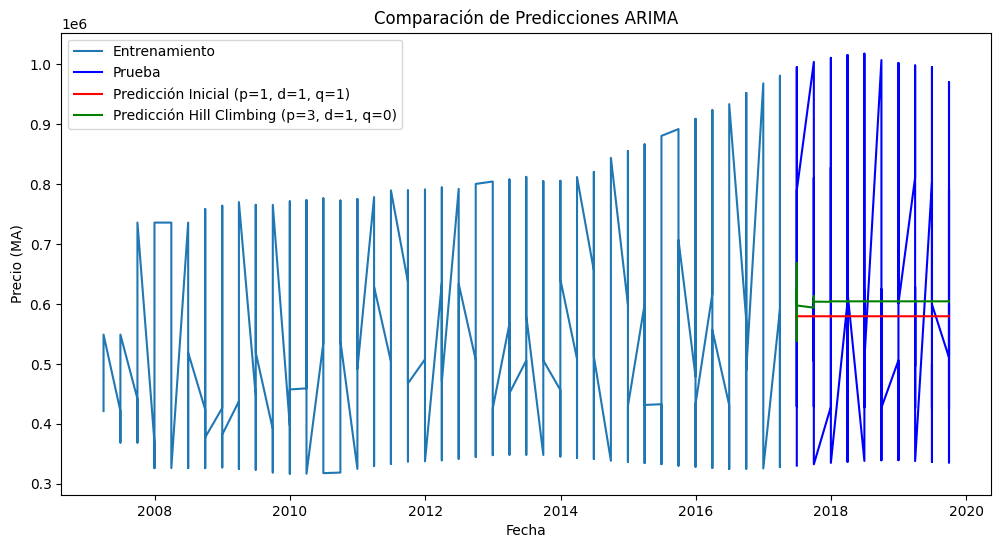

Parámetros iniciales: p=1, d=1, q=1
Error cuadrático medio (MSE) inicial: 46749952031.0084
Raíz del error cuadrático medio (RMSE) inicial: 216217.37217672498
Mejores parámetros encontrados: p=3, d=1, q=0
Error cuadrático medio (MSE) optimizado: 45089717328.55228
Raíz del error cuadrático medio (RMSE) optimizado: 212343.39483146698


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import random

df = pd.read_csv("/content/drive/MyDrive/iadataset.csv")
df['saledate'] = pd.to_datetime(df['saledate'], dayfirst=True)
df.set_index('saledate', inplace=True)
df.sort_index(inplace=True)

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

initial_model = ARIMA(train['MA'], order=(1, 1, 1))
initial_fitted_model = initial_model.fit()
initial_forecast = initial_fitted_model.forecast(steps=len(test))

initial_mse = mean_squared_error(test['MA'], initial_forecast)
initial_rmse = np.sqrt(initial_mse)

def evaluate_arima(order):
    try:
        model = ARIMA(train['MA'], order=order)
        fitted_model = model.fit()
        forecast = fitted_model.forecast(steps=len(test))
        mse = mean_squared_error(test['MA'], forecast)
        return mse
    except:
        return float('inf')

def hill_climbing_arima(p_range, d_range, q_range, max_iterations=100):
    best_order = (random.choice(p_range), random.choice(d_range), random.choice(q_range))
    best_mse = evaluate_arima(best_order)
    iterations = 0
    while iterations < max_iterations:
        candidate_order = (
            random.choice([best_order[0] - 1, best_order[0], best_order[0] + 1]),
            random.choice([best_order[1] - 1, best_order[1], best_order[1] + 1]),
            random.choice([best_order[2] - 1, best_order[2], best_order[2] + 1])
        )
        if candidate_order[0] < 0 or candidate_order[1] < 0 or candidate_order[2] < 0:
            continue
        candidate_mse = evaluate_arima(candidate_order)
        if candidate_mse < best_mse:
            best_order, best_mse = candidate_order, candidate_mse
        iterations += 1
    return best_order, best_mse

p_range = range(0, 5)
d_range = range(0, 3)
q_range = range(0, 5)

best_order, best_mse = hill_climbing_arima(p_range, d_range, q_range)
best_model = ARIMA(train['MA'], order=best_order)
best_fitted_model = best_model.fit()
best_forecast = best_fitted_model.forecast(steps=len(test))

best_rmse = np.sqrt(best_mse)

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['MA'], label='Entrenamiento')
plt.plot(test.index, test['MA'], label='Prueba', color='blue')
plt.plot(test.index, initial_forecast, label='Predicción Inicial (p=1, d=1, q=1)', color='red')
plt.plot(test.index, best_forecast, label=f'Predicción Hill Climbing (p={best_order[0]}, d={best_order[1]}, q={best_order[2]})', color='green')
plt.xlabel('Fecha')
plt.ylabel('Precio (MA)')
plt.title('Comparación de Predicciones ARIMA')
plt.legend()
plt.show()

print(f'Parámetros iniciales: p=1, d=1, q=1')
print(f'Error cuadrático medio (MSE) inicial: {initial_mse}')
print(f'Raíz del error cuadrático medio (RMSE) inicial: {initial_rmse}')
print(f'Mejores parámetros encontrados: p={best_order[0]}, d={best_order[1]}, q={best_order[2]}')
print(f'Error cuadrático medio (MSE) optimizado: {best_mse}')
print(f'Raíz del error cuadrático medio (RMSE) optimizado: {best_rmse}')

### 3.3. Algoritmo Genético

In [ ]:
!pip install deap

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/pyth

gen	nevals
0  	50    


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/

1  	41    


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/

2  	37    


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/

3  	34    


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dis

4  	33    


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/

5  	43    


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dis

6  	37    


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/

7  	42    


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dis

8  	32    


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dis

9  	35    


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dis

10 	38    


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dis

11 	39    


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dis

12 	32    


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dis

13 	41    


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/

14 	41    


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dis

15 	31    


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dis

16 	38    


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dis

17 	38    


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dis

18 	35    


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dis

19 	40    


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dis

20 	43    
Mejores parámetros encontrados: p=5, d=2, q=4


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dis

Error cuadrático medio (MSE) con parámetros optimizados: 45134299511.83591
Raíz del error cuadrático medio (RMSE) con parámetros optimizados: 212448.34551447065
Error cuadrático medio (MSE) con parámetros iniciales: 46749952031.0084
Raíz del error cuadrático medio (RMSE) con parámetros iniciales: 216217.37217672498


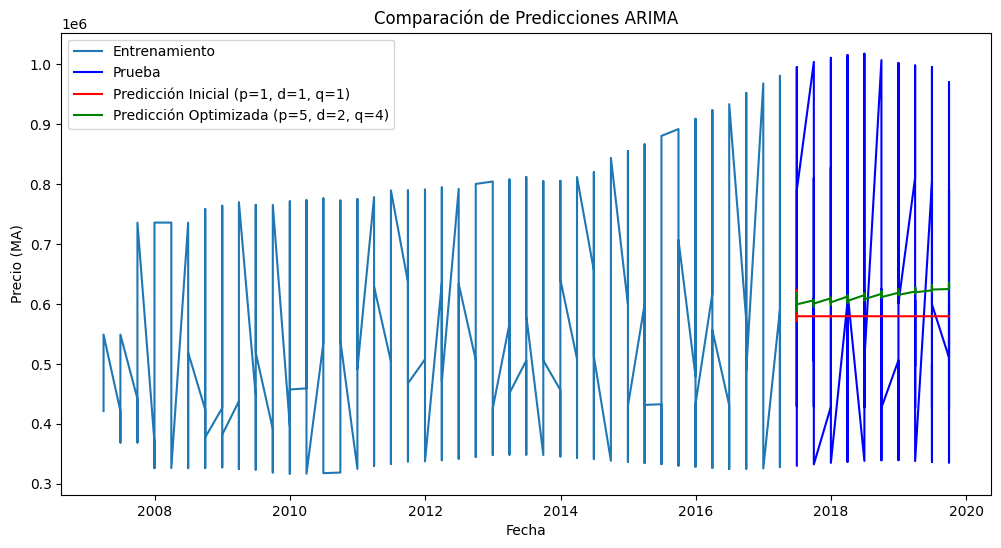

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

# Asegúrate de que 'saledate' esté en formato datetime y sea el índice del DataFrame
df['saledate'] = pd.to_datetime(df['saledate'], dayfirst=True)
df.set_index('saledate', inplace=True)
df.sort_index(inplace=True)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Definir la función de evaluación para el algoritmo genético
def evaluar_arima(individual):
    p, d, q = individual
    try:
        model = ARIMA(train['MA'], order=(p, d, q))
        fitted_model = model.fit()
        forecast = fitted_model.forecast(steps=len(test))
        mse = mean_squared_error(test['MA'], forecast)
        return mse,
    except:
        return float('inf'),

# Configurar el algoritmo genético utilizando DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 0, 5)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_int, toolbox.attr_int, toolbox.attr_int), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluar_arima)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=5, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Ejecutar el algoritmo genético
population_size = 50
num_generations = 20
crossover_probability = 0.7
mutation_probability = 0.2
population = toolbox.population(n=population_size)
result_population, logbook = algorithms.eaSimple(population, toolbox,
                                                 cxpb=crossover_probability,
                                                 mutpb=mutation_probability,
                                                 ngen=num_generations,
                                                 verbose=True)

# Obtener los mejores parámetros encontrados
best_individual = tools.selBest(result_population, k=1)[0]
best_p, best_d, best_q = best_individual
print(f'Mejores parámetros encontrados: p={best_p}, d={best_d}, q={best_q}')

# Entrenar el modelo ARIMA con los mejores parámetros
best_model = ARIMA(train['MA'], order=(best_p, best_d, best_q))
best_fitted_model = best_model.fit()

# Realizar la predicción
best_forecast = best_fitted_model.forecast(steps=len(test))

# Calcular el error cuadrático medio (MSE) y la raíz del error cuadrático medio (RMSE)
best_mse = mean_squared_error(test['MA'], best_forecast)
best_rmse = np.sqrt(best_mse)
print(f'Error cuadrático medio (MSE) con parámetros optimizados: {best_mse}')
print(f'Raíz del error cuadrático medio (RMSE) con parámetros optimizados: {best_rmse}')

# Comparar con el modelo inicial
initial_model = ARIMA(train['MA'], order=(1, 1, 1))
initial_fitted_model = initial_model.fit()
initial_forecast = initial_fitted_model.forecast(steps=len(test))
initial_mse = mean_squared_error(test['MA'], initial_forecast)
initial_rmse = np.sqrt(initial_mse)
print(f'Error cuadrático medio (MSE) con parámetros iniciales: {initial_mse}')
print(f'Raíz del error cuadrático medio (RMSE) con parámetros iniciales: {initial_rmse}')

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['MA'], label='Entrenamiento')
plt.plot(test.index, test['MA'], label='Prueba', color='blue')
plt.plot(test.index, initial_forecast, label='Predicción Inicial (p=1, d=1, q=1)', color='red')
plt.plot(test.index, best_forecast, label=f'Predicción Optimizada (p={best_p}, d={best_d}, q={best_q})', color='green')
plt.xlabel('Fecha')
plt.ylabel('Precio (MA)')
plt.title('Comparación de Predicciones ARIMA')
plt.legend()
plt.show()


## **4. VAR**

El segundo modelo que implementaremos en el proyecto es el **VAR (Vector Autoregressive)**. Este es un modelo estadístico tradicional utilizado en series de tiempo multivariadas. A diferencia del ARIMA, el VAR puede capturar las relaciones entre múltiples variables en un mismo modelo.

- Es **multivariado**, lo que significa que considera varias variables a la vez y no solo la variable objetivo de interés.

- El modelo no requiere distinguir entre variables dependientes e independientes; todas son tratadas simétricamente.



El VAR captura las siguientes características:

- **Relaciones cruzadas entre variables**: Cada variable se modela en función de sus propios rezagos y de los rezagos de todas las demás variables incluidas en el modelo.

- **Estacionariedad**: Al igual que ARIMA, es importante que las series de tiempo sean estacionarias antes de aplicar el modelo.

- **Orden del modelo (lags)**: Determina cuántos periodos pasados se consideran al predecir el valor actual.

### 4.1. Modelo original

Los pasos a seguir para establecer el modelo VAR son los siguientes:

- Importar las bibliotecas necesarias.

- Preparar los datos: Asegurar que saledate esté en formato fecha y ordenada cronológicamente. Además, todas las variables deben estar en formato numérico o ser transformadas adecuadamente.

- Dividir los datos en conjuntos de entrenamiento y prueba (80% y 20%).

- Ajustar el modelo VAR: Utilizar el modelo estándar con un orden inicial de rezagos que puede ser ajustado posteriormente para mejorar el rendimiento.

- Realizar predicciones: Predecir las series de tiempo en función de las variables multivariadas.

- Evaluar el modelo: Calcular métricas como MSE y RMSE para comparar el desempeño del modelo con otros métodos.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Variable: MA
MSE: 52420292804.45083
RMSE: 228954.78331856453

Variable: type_encoded
MSE: 0.24698804970843474
RMSE: 0.4969789228009924

Variable: bedrooms
MSE: 1.572531710716508
RMSE: 1.2540062642253857



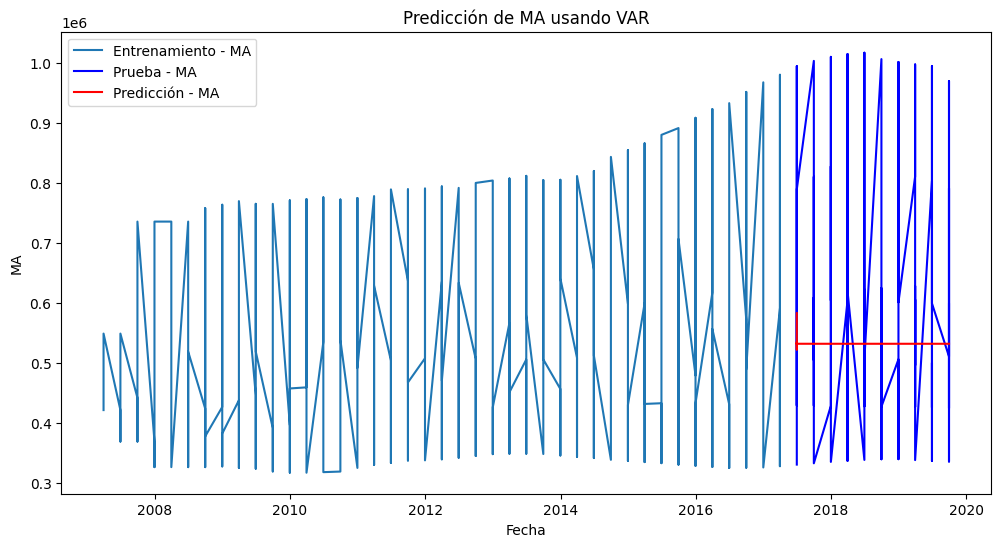

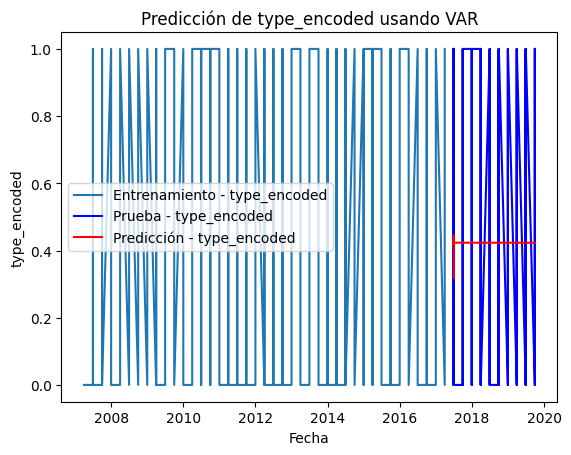

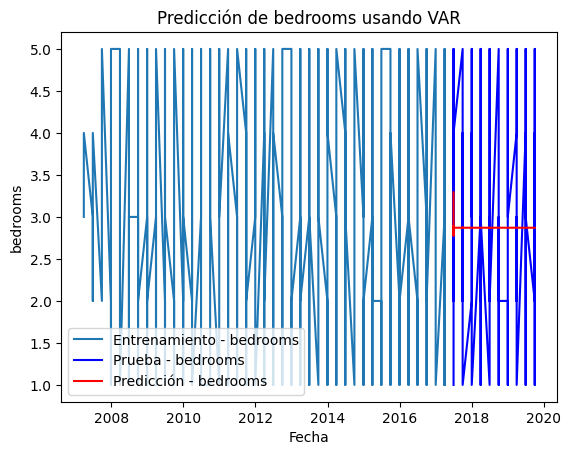

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("/content/drive/MyDrive/iadataset.csv")
df['saledate'] = pd.to_datetime(df['saledate'], dayfirst=True)
df.set_index('saledate', inplace=True)
df.sort_index(inplace=True)

df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
label_encoder = LabelEncoder()
df['type_encoded'] = label_encoder.fit_transform(df['type'])

variables = ['MA', 'type_encoded', 'bedrooms']
df = df[variables].dropna()

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

model = VAR(train)
fitted_model = model.fit()

lag_order = fitted_model.k_ar
forecast_input = train.values[-lag_order:]
forecast = fitted_model.forecast(y=forecast_input, steps=len(test))

forecast_df = pd.DataFrame(forecast, index=test.index, columns=test.columns)

for col in test.columns:
    mse = mean_squared_error(test[col], forecast_df[col])
    rmse = np.sqrt(mse)
    print(f'Variable: {col}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}\n')

plt.figure(figsize=(12, 6))
for col in test.columns:
    plt.plot(train.index, train[col], label=f'Entrenamiento - {col}')
    plt.plot(test.index, test[col], label=f'Prueba - {col}', color='blue')
    plt.plot(forecast_df.index, forecast_df[col], label=f'Predicción - {col}', color='red')
    plt.xlabel('Fecha')
    plt.ylabel(col)
    plt.title(f'Predicción de {col} usando VAR')
    plt.legend()
    plt.show()


### 4.2. Hill Climbing

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


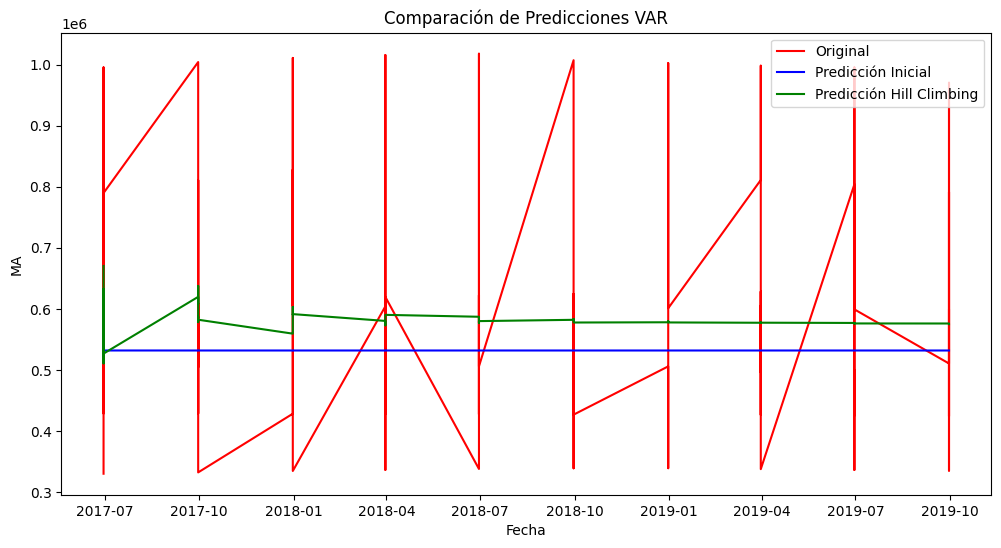

MSE Inicial: 26218629879.271606, RMSE Inicial: 161921.67822521974
MSE Optimizado: 23353468550.933372, RMSE Optimizado: 152818.41692326672


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
import random


df = pd.read_csv('/content/drive/MyDrive/iadataset.csv')
df['saledate'] = pd.to_datetime(df['saledate'], dayfirst=True)
df.set_index('saledate', inplace=True)
df.sort_index(inplace=True)

df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
df = df.dropna()

df = df[['MA', 'bedrooms']]

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

model = VAR(train)
initial_fitted_model = model.fit()
initial_forecast = initial_fitted_model.forecast(train.values, steps=len(test))

mse_initial = mean_squared_error(test.values, initial_forecast)
rmse_initial = np.sqrt(mse_initial)


def evaluate_var(lag_order):
    try:
        model = VAR(train)
        fitted_model = model.fit(lag_order)
        forecast = fitted_model.forecast(train.values, steps=len(test))
        mse = mean_squared_error(test.values, forecast)
        return mse
    except:
        return float('inf')

def hill_climbing_var(lag_range, max_iterations=100):
    best_lag = random.choice(lag_range)
    best_mse = evaluate_var(best_lag)
    iterations = 0
    while iterations < max_iterations:
        candidate_lag = random.choice([best_lag - 1, best_lag, best_lag + 1])
        if candidate_lag <= 0:
            continue
        candidate_mse = evaluate_var(candidate_lag)
        if candidate_mse < best_mse:
            best_lag, best_mse = candidate_lag, candidate_mse
        iterations += 1
    return best_lag, best_mse

lag_range = range(1, 11)
best_lag, best_mse = hill_climbing_var(lag_range)

best_model = VAR(train)
best_fitted_model = best_model.fit(best_lag)
best_forecast = best_fitted_model.forecast(train.values, steps=len(test))
mse_best = mean_squared_error(test.values, best_forecast)
rmse_best = np.sqrt(mse_best)

plt.figure(figsize=(12, 6))
plt.plot(test.index, test['MA'], label='Original', color='red')
plt.plot(test.index, [x[0] for x in initial_forecast], label='Predicción Inicial', color='blue')
plt.plot(test.index, [x[0] for x in best_forecast], label='Predicción Hill Climbing', color='green')
plt.xlabel('Fecha')
plt.ylabel('MA')
plt.title('Comparación de Predicciones VAR')
plt.legend()
plt.show()

print(f'MSE Inicial: {mse_initial}, RMSE Inicial: {rmse_initial}')
print(f'MSE Optimizado: {mse_best}, RMSE Optimizado: {rmse_best}')


### 4.3. Algoritmo Genético

<ipython-input-82-0697d69e03b2>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bedrooms'].fillna(df['bedrooms'].mode()[0], inplace=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no

MSE Original: 52420292804.450874
RMSE Original: 228954.78331856462
MSE Optimizado: 48245819042.45697
RMSE Optimizado: 219649.3092237191


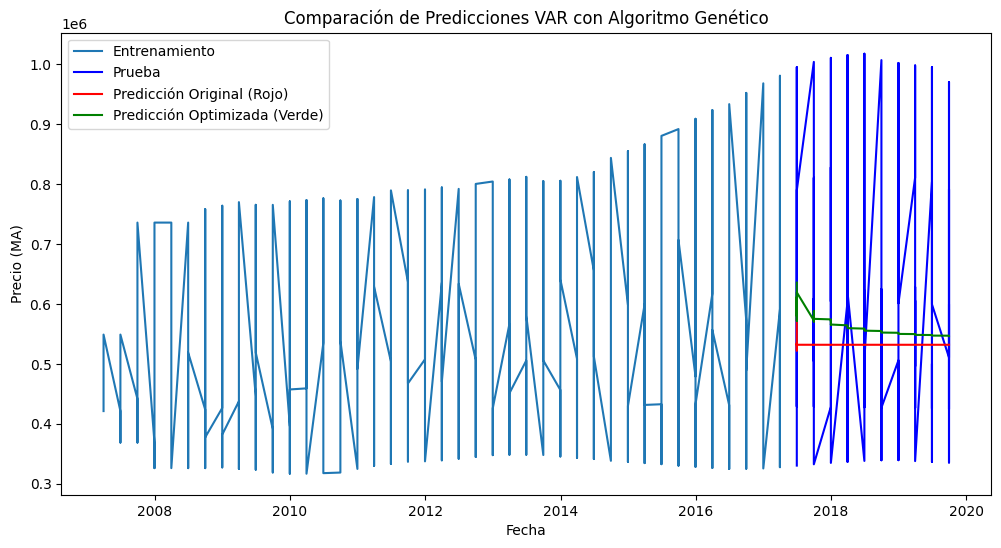

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
import random
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv('/content/drive/MyDrive/iadataset.csv')
df['saledate'] = pd.to_datetime(df['saledate'], dayfirst=True)
df.set_index('saledate', inplace=True)
df.sort_index(inplace=True)

df['bedrooms'].fillna(df['bedrooms'].mode()[0], inplace=True)

le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

def evaluate_var(lags):
    try:
        model = VAR(train[['MA', 'bedrooms', 'type']])
        var_model = model.fit(lags)
        var_forecast = var_model.forecast(train[['MA', 'bedrooms', 'type']].values, steps=len(test))
        test_forecast = pd.DataFrame(var_forecast, columns=['MA', 'bedrooms', 'type'], index=test.index)
        mse = mean_squared_error(test['MA'], test_forecast['MA'])
        return mse
    except:
        return float('inf')

def genetic_algorithm_var(population_size, generations):
    population = [random.randint(1, 5) for _ in range(population_size)]
    for generation in range(generations):
        scores = [(evaluate_var(lags), lags) for lags in population]
        scores.sort()
        population = [lags for _, lags in scores[:population_size//2]]
        offspring = []
        for lags in population:
            if random.random() < 0.5:
                lags = max(1, lags + random.choice([-1, 1]))
            offspring.append(lags)
        population.extend(offspring)
    best_lags = min(population, key=evaluate_var)
    return best_lags

original_model = VAR(train[['MA', 'bedrooms', 'type']])
original_fitted_model = original_model.fit()
original_forecast = original_fitted_model.forecast(train[['MA', 'bedrooms', 'type']].values, steps=len(test))
original_forecast_df = pd.DataFrame(original_forecast, columns=['MA', 'bedrooms', 'type'], index=test.index)

best_lags = genetic_algorithm_var(10, 5)
best_model = VAR(train[['MA', 'bedrooms', 'type']])
best_fitted_model = best_model.fit(best_lags)
best_forecast = best_fitted_model.forecast(train[['MA', 'bedrooms', 'type']].values, steps=len(test))
best_forecast_df = pd.DataFrame(best_forecast, columns=['MA', 'bedrooms', 'type'], index=test.index)

mse_original = mean_squared_error(test['MA'], original_forecast_df['MA'])
rmse_original = np.sqrt(mse_original)
mse_optimized = mean_squared_error(test['MA'], best_forecast_df['MA'])
rmse_optimized = np.sqrt(mse_optimized)

print(f'MSE Original: {mse_original}')
print(f'RMSE Original: {rmse_original}')
print(f'MSE Optimizado: {mse_optimized}')
print(f'RMSE Optimizado: {rmse_optimized}')

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['MA'], label='Entrenamiento')
plt.plot(test.index, test['MA'], label='Prueba', color='blue')
plt.plot(test.index, original_forecast_df['MA'], label='Predicción Original (Rojo)', color='red')
plt.plot(test.index, best_forecast_df['MA'], label='Predicción Optimizada (Verde)', color='green')
plt.xlabel('Fecha')
plt.ylabel('Precio (MA)')
plt.title('Comparación de Predicciones VAR con Algoritmo Genético')
plt.legend()
plt.show()


## **5. Random Forest (ML)**

### 5.1. Modelo original

In [111]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

df_rf = df.copy()
df_rf['saledate'] = pd.to_datetime(df_rf['saledate'], dayfirst=True)
df_rf.set_index('saledate', inplace=True, drop=False)
df_rf = pd.get_dummies(df_rf, columns=['type'])

train_size = int(len(df_rf) * 0.8)
train, test = df_rf.iloc[:train_size], df_rf.iloc[train_size:]

X_train = train.drop(['MA', 'saledate'], axis=1)
y_train = train['MA']
X_test = test.drop(['MA', 'saledate'], axis=1)
y_test = test['MA']

model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


MSE: 19880036499.78398
RMSE: 140996.5832911705
MAE: 121783.7686698424


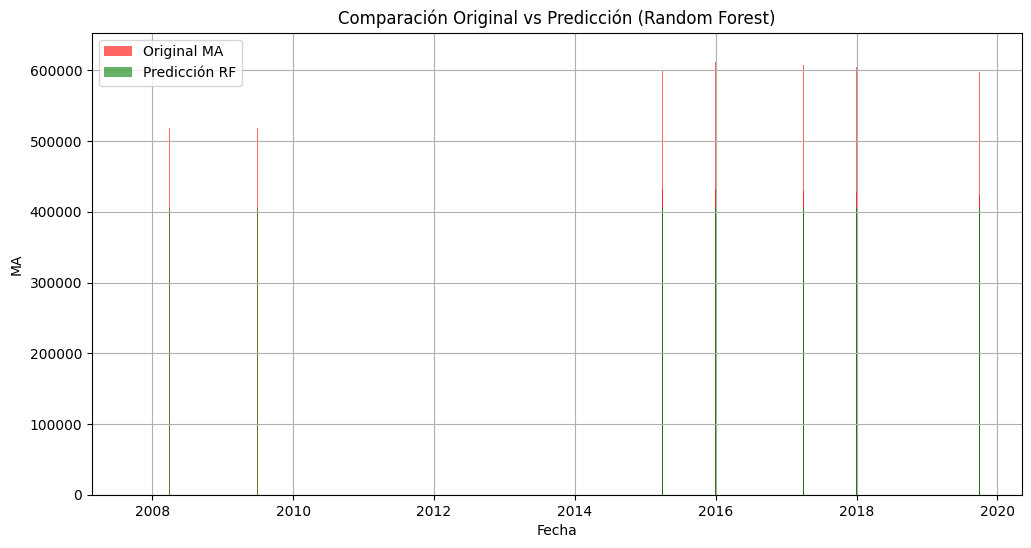

In [112]:
plt.figure(figsize=(12, 6))
plt.bar(y_test.index, y_test, color='red', label='Original MA', alpha=0.6, width=0.8)
plt.bar(y_test.index, predictions, color='green', label='Predicción RF', alpha=0.6, width=0.8)
plt.xlabel('Fecha')
plt.ylabel('MA')
plt.title('Comparación Original vs Predicción (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()


### 5.2. Hill Climbing

In [116]:
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

df_hc = df.copy()
df_hc['saledate'] = pd.to_datetime(df_hc['saledate'], dayfirst=True)
df_hc.set_index('saledate', inplace=True, drop=False)
df_hc = pd.get_dummies(df_hc, columns=['type'])

train_size = int(len(df_hc) * 0.8)
train, test = df_hc.iloc[:train_size], df_hc.iloc[train_size:]

X_train = train.drop(['MA', 'saledate'], axis=1)
y_train = train['MA']
X_test = test.drop(['MA', 'saledate'], axis=1)
y_test = test['MA']

def evaluate_model(n_estimators, max_depth):
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse, predictions

current_n_estimators = 100
current_max_depth = None
current_mse, original_predictions = evaluate_model(current_n_estimators, current_max_depth)

best_n_estimators = current_n_estimators
best_max_depth = current_max_depth
best_mse = current_mse
best_predictions = original_predictions

num_iterations = 1000

for iteration in range(num_iterations):
    new_n_estimators = best_n_estimators + random.randint(-10, 10)
    new_max_depth = None if best_max_depth is None else best_max_depth + random.randint(-3, 3)

    if new_n_estimators <= 0:
        continue

    new_mse, new_predictions = evaluate_model(new_n_estimators, new_max_depth)

    if new_mse < best_mse:
        best_n_estimators = new_n_estimators
        best_max_depth = new_max_depth
        best_mse = new_mse
        best_predictions = new_predictions
        print(f"Iteración {iteration + 1}: Mejor modelo encontrado - n_estimators={best_n_estimators}, max_depth={best_max_depth}, MSE={best_mse}")


Iteración 2: Mejor modelo encontrado - n_estimators=90, max_depth=None, MSE=19846175570.27539
Iteración 9: Mejor modelo encontrado - n_estimators=95, max_depth=None, MSE=19845883944.221813
Iteración 35: Mejor modelo encontrado - n_estimators=87, max_depth=None, MSE=19833904009.057907
Iteración 37: Mejor modelo encontrado - n_estimators=81, max_depth=None, MSE=19828352801.82699
Iteración 42: Mejor modelo encontrado - n_estimators=79, max_depth=None, MSE=19827599270.162308
Iteración 44: Mejor modelo encontrado - n_estimators=70, max_depth=None, MSE=19816845146.295677
Iteración 45: Mejor modelo encontrado - n_estimators=65, max_depth=None, MSE=19777496933.4298


### 5.3. Algoritmo Genético

In [117]:
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

df_ga = df.copy()
df_ga['saledate'] = pd.to_datetime(df_ga['saledate'], dayfirst=True)
df_ga.set_index('saledate', inplace=True, drop=False)
df_ga = pd.get_dummies(df_ga, columns=['type'])

train_size = int(len(df_ga) * 0.8)
train, test = df_ga.iloc[:train_size], df_ga.iloc[train_size:]

X_train = train.drop(['MA', 'saledate'], axis=1)
y_train = train['MA']
X_test = test.drop(['MA', 'saledate'], axis=1)
y_test = test['MA']

def evaluate_model(n_estimators, max_depth):
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse

population_size = 10
generations = 50
mutation_rate = 0.1

population = [(random.randint(10, 200), random.choice([None, random.randint(1, 20)])) for _ in range(population_size)]
best_solution = None
best_mse = float('inf')

for generation in range(generations):
    scored_population = [(evaluate_model(ind[0], ind[1]), ind) for ind in population]
    scored_population.sort(key=lambda x: x[0])

    if scored_population[0][0] < best_mse:
        best_mse = scored_population[0][0]
        best_solution = scored_population[0][1]

    print(f"Generación {generation + 1}: Mejor MSE = {best_mse}")

    parents = [ind for _, ind in scored_population[:population_size//2]]

    offspring = []
    for _ in range(population_size // 2):
        parent1 = random.choice(parents)
        parent2 = random.choice(parents)

        child_n_estimators = random.choice([parent1[0], parent2[0]])
        child_max_depth = random.choice([parent1[1], parent2[1]])

        if random.random() < mutation_rate:
            child_n_estimators = max(1, child_n_estimators + random.randint(-10, 10))
        if random.random() < mutation_rate and child_max_depth is not None:
            child_max_depth = max(1, child_max_depth + random.randint(-3, 3))

        offspring.append((child_n_estimators, child_max_depth))

    population = parents + offspring


Generación 1: Mejor MSE = 19699902843.800243
Generación 2: Mejor MSE = 19699902843.800243
Generación 3: Mejor MSE = 19699902843.800243
Generación 4: Mejor MSE = 19699902843.800243
Generación 5: Mejor MSE = 19699902843.800243
Generación 6: Mejor MSE = 19699902843.800243
Generación 7: Mejor MSE = 19699902843.800243
Generación 8: Mejor MSE = 19699902843.800243
Generación 9: Mejor MSE = 19699902843.800243
Generación 10: Mejor MSE = 19699902843.800243
Generación 11: Mejor MSE = 19699902843.800243
Generación 12: Mejor MSE = 19699902843.800243
Generación 13: Mejor MSE = 19699902843.800243
Generación 14: Mejor MSE = 19699902843.800243
Generación 15: Mejor MSE = 19699902843.800243
Generación 16: Mejor MSE = 19699902843.800243
Generación 17: Mejor MSE = 19690182510.28066
Generación 18: Mejor MSE = 19690182510.28066
Generación 19: Mejor MSE = 19690182510.28066
Generación 20: Mejor MSE = 19690182510.28066
Generación 21: Mejor MSE = 19690182510.28066
Generación 22: Mejor MSE = 19690182510.28066
Gen